<h1 style="text-align: center;">H04U1C - Optimization of Mechatronic Systems</h1>

Consider the two-link planar robot arm described in Chapter 8 of Modern Robotics (http://modernrobotics.org/). For additional background information, you can consult this book, section 8.1.

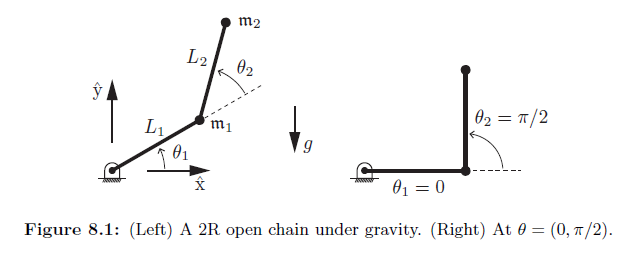

The equations of motion of this robot are given by: 

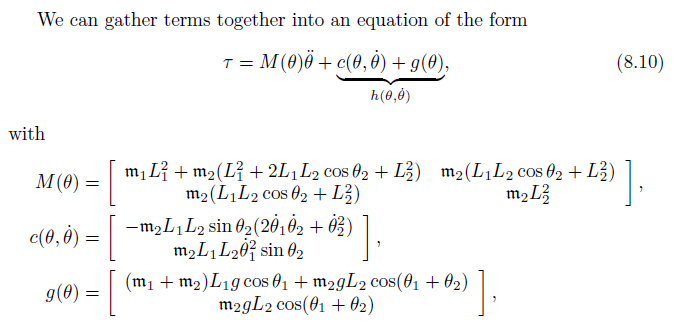

with:

* $\tau$: joint torques
* $\theta$: joint positions
* $m$: masses (assumed to be concentrated at the tip of the links)
* $L$: lengths.

Assume the following values: $L_1 = 0.5 \text{ m}$, $L_2 = 0.3 \text{ m}$, $m_1 = 3 \text{ kg}$, $m_2 = 1 \text{ kg}$.

Questions:

1. Write down the system dynamics equation for this robot in state-space form, such that we can use it in an optimal control problem, for the following two cases:

    a. case 1: assuming the robot is acceleration-controlled: the states are the joint positions $\theta$ and the joint velocities $\dot{\theta}$, and the controls are the desired joint accelerations $\ddot{\theta_r}$. You can assume that the acceleration controller is perfect, such that $\ddot{\theta_r} \equiv \ddot{\theta}$.
    
    b. case 2: assuming the robot is torque-controlled: the states are the joint positions $\theta$ and the joint velocities $\dot{\theta}$, and the controls are the desired joint torques $\tau_r$. You can assume that the torque controller is perfect, such that $\tau_r \equiv \tau$.

2. Formulate for both cases an optimal control problem that 

    a. minimizes the mean-square control effort (so mean-square joint acceleration for case 1, and mean-square joint torque for case 2), 
    
    b. moves the robot from initial joint positions $\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$ to terminal joint positions $\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ in $2$ seconds,

    c. starts and terminates with zero joint velocities, and

    d. the robot avoids self-collision.
    
    Implement and solve these two problems, and plot the resulting state and control trajectories.
    Are these two optimization problems convex or not? Briefly motivate your answer.

3. For case 1 (acceleration-controlled robot), formulate a time-optimal control problem that

    a. moves from initial joint positions $\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$ to terminal joint positions $\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ (in minimum time), and

    b. starts and terminates with zero joint velocities,

    c. satisfies the following control bounds: $-10 \text{ rad}/\text{s}^2 \leq \ddot{\theta_r} \leq 10 \text{ rad}/\text{s}^2$,

    d. the robot avoids self-collision, 

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).

    Is this problem convex or not? Briefly motivate your answer.
    Implement and solve this problem and plot the resulting state and control trajectories.

4. Write down the forward kinematics equation for this robot. This is the function $f$ such that $[x, y, \alpha]^T = f(\theta_1,\theta_2)$, with $x$, $y$ and $\alpha$ the pose (position and orientation) of the end effector ($m_2$).

5. For case 2 (torque-controlled robot), formulate an optimal control problem that

    a. minimizes the mean-square control effort (so the mean-square joint torques), and
    
    b. moves the robot from initial end effector pose $[0.8 \text{ m} , 0.0 \text{ m}, 0.0 \text{ rad}]^T$ to terminal end effector pose $[0.4 \text{ m} , 0.4 \text{ m}, 1.8 \text{ rad}]^T$ in $2$ seconds, and

    c. starts and terminates with zero joint velocities,

    d. the robot avoids self-collision, and

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).
    
    Implement and (try to) solve this problem. Do you get a solution? If yes, plot the resulting state and control trajectories. If not, explain what is problematic with the problem description, make a suggestion how we could modify the problem formulation and solve the modified problem.

## Q1 - System dynamics equation in state-space form

$
M(\theta_1, \theta_2) = \begin{bmatrix}
m_1 l_1^2 + m_2 (l_1^2 + 2 l_1 l_2 \cos(\theta_2) + l_2^2) & m_2 (l_1 l_2 \cos(\theta_2) + l_2^2) \\
m_2 (l_1 l_2 \cos(\theta_2) + l_2^2) & m_2 l_2^2
\end{bmatrix}
$

$
c(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) = \begin{bmatrix}
-m_2 l_1 l_2 \sin(\theta_2) \dot{\theta}_2 (2 \dot{\theta}_1 + \dot{\theta}_2) \\
m_2 l_1 l_2 \sin(\theta_2) \dot{\theta}_1^2
\end{bmatrix}
$

$
g(\theta_1, \theta_2) = \begin{bmatrix}
(m_1 + m_2) l_1 g \cos(\theta_1) + m_2 l_2 g \cos(\theta_1 + \theta_2) \\
m_2 l_2 g \cos(\theta_1 + \theta_2)
\end{bmatrix}
$

Therefore, the system dynamics equation in state-space form is:

$
\begin{aligned}
    \ddot{\theta} &= M(\theta_1, \theta_2)^{-1} \Bigg( \begin{bmatrix}
    \tau_1 \\
    \tau_2
    \end{bmatrix} - c(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) - g(\theta_1, \theta_2) \Bigg) \\
    &= \begin{bmatrix}
    m_1 l_1^2 + m_2 (l_1^2 + 2 l_1 l_2 \cos(\theta_2) + l_2^2) & m_2 (l_1 l_2 \cos(\theta_2) + l_2^2) \\
    m_2 (l_1 l_2 \cos(\theta_2) + l_2^2) & m_2 l_2^2
    \end{bmatrix}^{-1} \begin{bmatrix}
    \tau_1 + m_2 l_1 l_2 \sin(\theta_2) \dot{\theta}_2 (2 \dot{\theta}_1 + \dot{\theta}_2) - (m_1 + m_2) l_1 g \cos(\theta_1) - m_2 l_2 g \cos(\theta_1 + \theta_2)\\
    \tau_2 - m_2 l_1 l_2 \sin(\theta_2) \dot{\theta}_1^2 - m_2 l_2 g \cos(\theta_1 + \theta_2)
    \end{bmatrix}
\end{aligned} 
$

### Case 1 - Acceleration-controlled robot 

The state-space representation of this case is in linear form:  
\begin{align}
  \dot{x}(t) &= A x(t) + B u(t) \\
   y(t) &= C x(t) + D u(t)
\end{align}  

The dynamics equation in state-space model:  

$
\begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix}=\begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix}+\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \ddot{\theta_1} \\ \ddot{\theta}_2 \end{bmatrix}  
$  

$
\begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix}
$
   


The mean-square control effort for a system with control inputs $u(t)$ over a time horizon $[0,T]$ can be expressed as:

$ J = \frac{1}{T} \int_{0}^{T} \|u(t)\|^2 \ dt 
 = \frac{1}{T} \int_{0}^{T} \left( \ddot{\theta}_1^2 + \ddot{\theta}_2^2 \right) \, dt
$

In [ ]:
from casadi import *
from rockit import *
import numpy as np
import imageio, io
import matplotlib.pyplot as plt
from matplotlib.animation import *

# Define the system's parameters
m1 = 3      # kg
m2 = 1      # kg
l1 = 0.5    # m
l2 = 0.3    # m
g = 9.81    # m/s^2

In [ ]:
def create_anim(sol, case, theta1, theta2, theta1_dot, theta2_dot, control1, control2, name='robot_arm_animation.gif'):
    # Sample the values from the solution
    time, theta1_sol = sol.sample(theta1, grid='integrator', refine=20)
    _, theta2_sol = sol.sample(theta2, grid='integrator', refine=20)
    _, theta1_dot_sol = sol.sample(theta1_dot, grid='integrator', refine=20)
    _, theta2_dot_sol = sol.sample(theta2_dot, grid='integrator', refine=20)
    _, control1_sol = sol.sample(control1, grid='integrator', refine=20)
    _, control2_sol = sol.sample(control2, grid='integrator', refine=20)

    # Calculate the positions of the joints and end effector
    x1 = l1 * np.cos(theta1_sol)
    y1 = l1 * np.sin(theta1_sol)
    x2 = x1 + l2 * np.cos(theta1_sol + theta2_sol)
    y2 = y1 + l2 * np.sin(theta1_sol + theta2_sol)

    # Create a figure and axis for the animation
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))

    # Set limits and labels for the robot arm plot
    axs[0, 0].set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
    axs[0, 0].set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_title('Robot Arm Movement')
    axs[0, 0].set_xlabel('X [m]')
    axs[0, 0].set_ylabel('Y [m]')
    axs[0, 0].grid(True)
    line1, = axs[0, 0].plot([], [], 'o-', lw=2, label='Link 1')
    line2, = axs[0, 0].plot([], [], 'o-', lw=2, label='Link 2')

    # Initialize the points for the states and inputs
    theta1_points, = axs[1, 0].plot([], [], 'b.', label=r'$\theta_1$ [rad]')
    theta2_points, = axs[1, 1].plot([], [], 'r.', label=r'$\theta_2$ [rad]')
    theta1_dot_points, = axs[2, 0].plot([], [], 'b.', label=r'$\dot{\theta}_1$ [rad/s]')
    theta2_dot_points, = axs[2, 1].plot([], [], 'r.', label=r'$\dot{\theta}_2$ [rad/s]')
    control1_points, = axs[3, 0].plot([], [], 'b.', label=r'$\ddot{\theta}_1$ [rad/$s^2$]' if case == 1 else r'$\tau_1$ [Nm]')
    control2_points, = axs[3, 1].plot([], [], 'r.',label=r'$\ddot{\theta}_1$ [rad/$s^2$]' if case == 1 else r'$\tau_2$ [Nm]')

    # Set titles and labels for the plots
    axs[0, 1].axis('off')
    #axs[1, 0].set_title('Joint Angles')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    #axs[1, 1].set_title('Joint Angles')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    #axs[2, 0].set_title('Joint Velocities')
    axs[2, 0].legend()
    axs[2, 0].grid(True)
    #axs[2, 1].set_title('Joint Velocities')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    #axs[3, 0].set_title('Joint Torques')
    axs[3, 0].set_xlabel('Time [s]')
    axs[3, 0].legend()
    axs[3, 0].grid(True)
    #axs[3, 1].set_title('Joint Torques')
    axs[3, 1].set_xlabel('Time [s]')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    # Initialize the animation
    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        theta1_points.set_data([], [])
        theta2_points.set_data([], [])
        theta1_dot_points.set_data([], [])
        theta2_dot_points.set_data([], [])
        control1_points.set_data([], [])
        control2_points.set_data([], [])
        
        return line1, line2, theta1_points, theta2_points, theta1_dot_points, theta2_dot_points, control1_points, control2_points

    # Update function for the animation
    def padded_update(frame):
        if frame < len(time):  # Normal animation frames
            line1.set_data([0, x1[frame]], [0, y1[frame]])
            line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
            theta1_points.set_data(time[:frame], theta1_sol[:frame])
            theta2_points.set_data(time[:frame], theta2_sol[:frame])
            theta1_dot_points.set_data(time[:frame], theta1_dot_sol[:frame])
            theta2_dot_points.set_data(time[:frame], theta2_dot_sol[:frame])
            control1_points.set_data(time[:frame], control1_sol[:frame])
            control2_points.set_data(time[:frame], control2_sol[:frame])
        else:  # Pause by holding the last frame
            last_frame = len(time) - 1
            line1.set_data([0, x1[last_frame]], [0, y1[last_frame]])
            line2.set_data([x1[last_frame], x2[last_frame]], [y1[last_frame], y2[last_frame]])
            theta1_points.set_data(time, theta1_sol)
            theta2_points.set_data(time, theta2_sol)
            theta1_dot_points.set_data(time, theta1_dot_sol)
            theta2_dot_points.set_data(time, theta2_dot_sol)
            control1_points.set_data(time, control1_sol)
            control2_points.set_data(time, control2_sol)

        # Autoscale the axes
        axs[1, 0].relim()
        axs[1, 0].autoscale_view()
        axs[1, 1].relim()
        axs[1, 1].autoscale_view()
        axs[2, 0].relim()
        axs[2, 0].autoscale_view()
        axs[2, 1].relim()
        axs[2, 1].autoscale_view()
        axs[3, 0].relim()
        axs[3, 0].autoscale_view()
        axs[3, 1].relim()
        axs[3, 1].autoscale_view()

        return line1, line2, theta1_points, theta2_points, theta1_dot_points, theta2_dot_points, control1_points, control2_points

    # Create the animation
    animation = FuncAnimation(fig=fig, func=padded_update, frames=len(time)+int(1000/20), init_func=init, blit=True)
    animation.save(name, writer='pillow')

In [ ]:
# Function to create individual frames
def create_animation(sol, case, theta1, theta2, theta1_dot, theta2_dot, control1, control2, name="robot_arm_animation.gif", fps=30):
    # Sample the values from the solution
    time, theta1_sol = sol.sample(theta1, grid='integrator', refine=20)
    _, theta2_sol = sol.sample(theta2, grid='integrator',  refine=20)
    _, theta1_dot_sol = sol.sample(theta1_dot, grid='integrator', refine=20)
    _, theta2_dot_sol = sol.sample(theta2_dot, grid='integrator', refine=20)
    _, control1_sol = sol.sample(control1, grid='integrator', refine=20)
    _, control2_sol = sol.sample(control2, grid='integrator', refine=20)

    # Calculate the positions of the joints and end effector
    x1 = l1 * np.cos(theta1_sol)
    y1 = l1 * np.sin(theta1_sol)
    x2 = x1 + l2 * np.cos(theta1_sol + theta2_sol)
    y2 = y1 + l2 * np.sin(theta1_sol + theta2_sol)

    # Generate frames
    with imageio.get_writer(name, mode='I', duration=1/fps) as writer:
        for i in range(len(time)):
            fig, axs = plt.subplots(4, 2, figsize=(15, 15))

            # Set limits and labels for the robot arm plot
            axs[0, 0].set_xlim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
            axs[0, 0].set_ylim(-l1 - l2 - 0.1, l1 + l2 + 0.1)
            axs[0, 0].set_aspect('equal')
            axs[0, 0].set_title('Robot Arm Movement')
            axs[0, 0].set_xlabel('X [m]')
            axs[0, 0].set_ylabel('Y [m]')
            axs[0, 0].plot([0, x1[i]], [0, y1[i]], 'o-', lw=2, label='Link 1')
            axs[0, 0].plot([x1[i], x2[i]], [y1[i], y2[i]], 'o-', lw=2, label='Link 2')
            axs[0, 0].grid(True)
            axs[0, 0].legend()
            axs[0, 1].axis('off')

            # Plot the states and inputs
            axs[1, 0].plot(time[:i+1], theta1_sol[:i+1], 'b.', label=r'$\theta_1$ [rad]')
            axs[1, 0].legend()
            axs[1, 0].grid(True)

            axs[1, 1].plot(time[:i+1], theta2_sol[:i+1], 'r.', label=r'$\theta_2$ [rad]')
            axs[1, 1].legend()
            axs[1, 1].grid(True)

            axs[2, 0].plot(time[:i+1], theta1_dot_sol[:i+1], 'b.', label=r'$\dot{\theta}_1$ [rad/s]')
            axs[2, 0].legend()
            axs[2, 0].grid(True)

            axs[2, 1].plot(time[:i+1], theta2_dot_sol[:i+1], 'r.', label=r'$\dot{\theta}_2$ [rad/s]')
            axs[2, 1].legend()
            axs[2, 1].grid(True)

            axs[3, 0].plot(time[:i+1], control1_sol[:i+1], 'b.', label=r'$\ddot{\theta}_1$ [rad/s^2]' if case == 1 else r'$\tau_1$ [Nm]')
            axs[3, 0].set_xlabel('Time [s]')
            axs[3, 0].legend()
            axs[3, 0].grid(True)

            axs[3, 1].plot(time[:i+1], control2_sol[:i+1], 'r.', label=r'$\ddot{\theta}_2$ [rad/s^2]' if case == 1 else r'$\tau_2$ [Nm]')
            axs[3, 1].set_xlabel('Time [s]')
            axs[3, 1].legend()
            axs[3, 1].grid(True)

            # Save the frame to a buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            image = imageio.imread(buf)
            writer.append_data(image)
            plt.close(fig)

        # Add delay at the end of the GIF
        for _ in range(fps * 2):  # 2 seconds delay
            writer.append_data(image)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1408
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      604
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      101

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.90e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

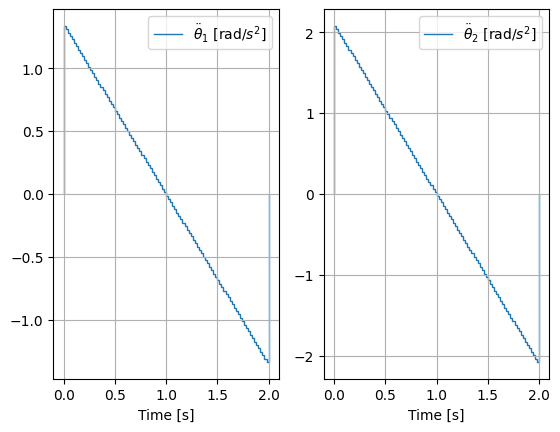

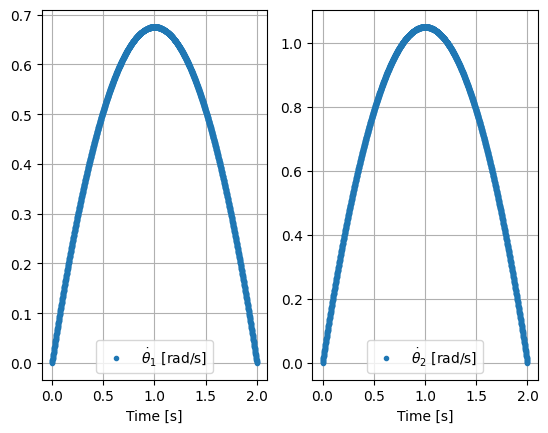

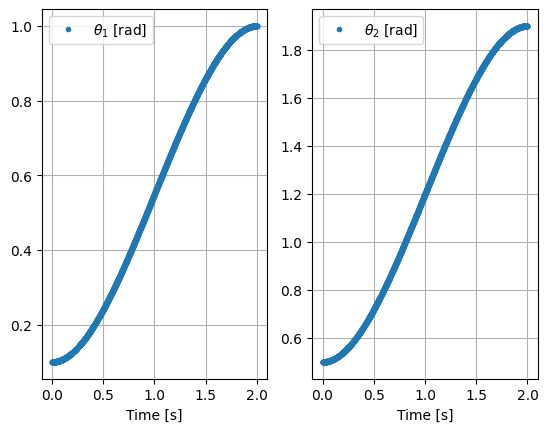

In [ ]:
def manipulator(case, animation=False):
    # Define the dynamics
    def M(theta1, theta2):
        return vertcat(horzcat(m1*l1**2 + m2*(l1**2 + 2*l1*l2*cos(theta2) + l2**2), m2*(l1*l2*cos(theta2) + l2**2)),
                        horzcat(m2*(l1*l2*cos(theta2) + l2**2), m2*l2**2) )

    def c(theta1, theta2, theta1_dot, theta2_dot):
        return vertcat(-m2*l1*l2*sin(theta2)*theta2_dot*(2*theta1_dot + theta2_dot),
                    m2*l1*l2*sin(theta2)*theta1_dot**2)

    def g(theta1, theta2):
        return vertcat((m1 + m2)*l1*9.81*cos(theta1) + m2*l2*9.81*cos(theta1+theta2),
                    m2*l2*9.81*cos(theta1+theta2))

    def f(theta1, theta2, theta1_dot, theta2_dot, torque1=0, torque2=0): # Returns \ddot{\theta} = M^(-1) * (torque - c - g) 
        M_ = M(theta1, theta2)
        c_ = c(theta1, theta2, theta1_dot, theta2_dot)
        g_ = g(theta1, theta2)
        return solve(M_, vertcat(torque1 - c_[0] - g_[0], torque2 - c_[1] - g_[1]))

    ocp = Ocp(T=2.0) # Time horizon

    # Define the states
    theta1 = ocp.state()
    theta2 = ocp.state()
    theta1_dot = ocp.state()
    theta2_dot = ocp.state()

    # Defince controls
    if case == 1:
        theta1_ddot = ocp.control()
        theta2_ddot = ocp.control()
    elif case == 2:
        torque1 = ocp.control()
        torque2 = ocp.control()

    # Specify ODE
    ocp.set_der(theta1, theta1_dot)
    ocp.set_der(theta2, theta2_dot)
    if case == 1:
        ocp.set_der(theta1_dot, theta1_ddot)
        ocp.set_der(theta2_dot, theta2_ddot)
    elif case == 2:
        ocp.set_der(theta1_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[0])
        ocp.set_der(theta2_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[1])

    # Lagrange objective
    if case == 1:
        obj = ocp.integral(theta1_ddot**2 + theta2_ddot**2) / 2
    elif case == 2:
        obj = ocp.integral(torque1**2 + torque2**2) / 2
    ocp.add_objective(obj)

    # Motion constraints
    epsilon = 1e-2
    ocp.subject_to(theta2 <= pi - epsilon)  # Ensure theta2 is less than pi - epsilon
    ocp.subject_to(theta2 >= -pi + epsilon)  # Ensure theta2 is greater than -pi + epsilon
    # check if this is enough to avoid self-collision

    # Initial constraints
    ocp.subject_to(ocp.at_t0(theta1)==0.1)
    ocp.subject_to(ocp.at_t0(theta2)==0.5)
    ocp.subject_to(ocp.at_t0(theta1_dot)==0.)
    ocp.subject_to(ocp.at_t0(theta2_dot)==0.)

    # End constraints
    ocp.subject_to(ocp.at_tf(theta1)==1.0)
    ocp.subject_to(ocp.at_tf(theta2)==1.9)
    ocp.subject_to(ocp.at_tf(theta1_dot)==0.)
    ocp.subject_to(ocp.at_tf(theta2_dot)==0.)

    # Pick a solver
    ocp.solver('ipopt')

    # Pick a solution method
    ocp.method(MultipleShooting(N=100, M=1, intg='rk'))#change shooting interval, we can get different trajecotry for torque control

    # Solve the OCP
    sol = ocp.solve()

    # Plot the solution
    if case == 1:
        t_u1, theta1_ddot_sol = sol.sample(theta1_ddot, grid='control')
        t_u2, theta2_ddot_sol = sol.sample(theta2_ddot, grid='control')
    elif case == 2:
        t_u1, torque1_sol = sol.sample(torque1, grid='control')
        t_u2, torque2_sol = sol.sample(torque2, grid='control')
    
    t_x1, theta1_sol = sol.sample(theta1,  grid='integrator', refine=20)
    t_x2, theta2_sol = sol.sample(theta2,  grid='integrator', refine=20)
    t_x3, theta1_dot_sol = sol.sample(theta1_dot,  grid='integrator', refine=20)
    t_x4, theta2_dot_sol = sol.sample(theta2_dot,  grid='integrator', refine=20)

    if case == 1:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.stairs(theta1_ddot_sol[:-1], t_u1, label=r'$\ddot{\theta}_1$ [rad/$s^2$]')
        plt.xlabel("Time [s]")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.stairs(theta2_ddot_sol[:-1], t_u2, label=r'$\ddot{\theta}_2$ [rad/$s^2$]')
        plt.xlabel("Time [s]")
        plt.legend()
        plt.grid(True)
        #filename = f"./imgs/Q2-acc.png"
        #plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
        plt.show()
        
    elif case == 2:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.stairs(torque1_sol[:-1], t_u1, label=r'$\tau_1$ [Nm]')
        plt.xlabel("Time [s]")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.stairs(torque2_sol[:-1], t_u2, label=r'$\tau_2$ [Nm]')
        plt.xlabel("Time [s]")
        plt.legend()
        plt.grid(True)
        #filename = f"./imgs/Q2-toques.png"
        #plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
        plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x3, theta1_dot_sol, '.', label=r'$\dot{\theta}_1$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x4, theta2_dot_sol, '.', label=r'$\dot{\theta}_2$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    #filename = f"./imgs/Q2-vel.png"
    #plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x1, theta1_sol, '.', label=r'$\theta_1$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x2, theta2_sol, '.', label=r'$\theta_2$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    #filename = f"./imgs/Q2-pos.png"
    #plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
    plt.show()

    # Create the animation
    if animation:
        if case == 1:
            name = 'Q1_1.gif'
            create_animation(sol, case, theta1, theta2, theta1_dot, theta2_dot, theta1_ddot, theta2_ddot, name=name)
        elif case == 2:
            name = 'Q1_2.gif'
            create_animation(sol, case, theta1, theta2, theta1_dot, theta2_dot, torque1, torque2, name=name)

    return sol

# Optimal control problem
sol = manipulator(1, animation=False)

### Convexity analysis for Case 1  
1. Object function: Mean-square control effort:  
The mean-square control effort for a system with control inputs $u(t)$ over a time horizon $[0,T]$ can be expressed as:

$ J = \frac{1}{T} \int_{0}^{T} \|u(t)\|^2 \ dt 
 = \frac{1}{T} \int_{0}^{T} \ u(t)^T \cdot u(t)  \, dt 
$

This is a quadratic function of the control inputs $\ u(t)$ :  
$ f(u) = \ u(t)^t Q u(t) $  
The function is convex if and only if matrix Q is positive semi-definite ($ Q \geq 0 $). In this case Q is 2*2 identity matrix which is positive semi-definite, so the objective function is convex.  

2. System dynamics: State-space representation  
As shown in Q1, the state-space model for case 1 is linear, where the matrices A, B and C suggest a linear system. A linear system with a quadratic objective function typically preserves convexity.  

3. Constraints  
The constraints of this problem are given by:  
$\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$  
$\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ in $2$ seconds  
$\dot{\theta}_{\text{initial}} = [0.0, 0.0]^T \text{ rad/s}$  
$\dot{\theta}_{\text{terminal}} = [0.0, 0.0]^T \text{ rad/s}$  
$|\theta_2| < \pi$  

The constraints for this problem is affine, linear constraints do not affect the convexity of an optimization problem.  

Based on the analysis above, the problem is a convex problem.



### Case 2 - Torque-controlled robot

 The state-space model of this case is a nonliner model:
\begin{align}
   \dot{x} &= f( x ,  u) \\
    y &= h( x , u)
\end{align}

The dynamics equation in state-space model:  
$
\begin{bmatrix} 
\dot{\theta}_1 \\ \dot{\theta}_2 \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ \mathbf{M}(\theta)^{-1} [\tau(\theta) - \mathbf{c}(\theta, \dot{\theta}) - \mathbf{g}(\theta)] \end{bmatrix} 
$  
$
\begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix}
$

The mean-square control effort for a system with control inputs $u(t)$ over a time horizon $[0,T]$ can be expressed as:

$ J = \frac{1}{T} \int_{0}^{T} \|u(t)\|^2 \ dt 
 = \frac{1}{T} \int_{0}^{T} \left( \tau_1^2 + \tau_2^2 \right) \, dt
$

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2808
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:      604
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      101

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.90e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

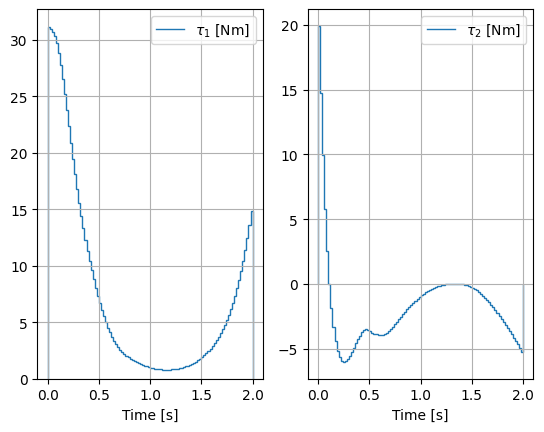

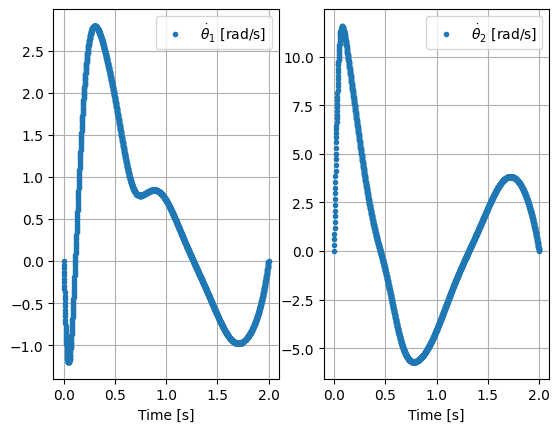

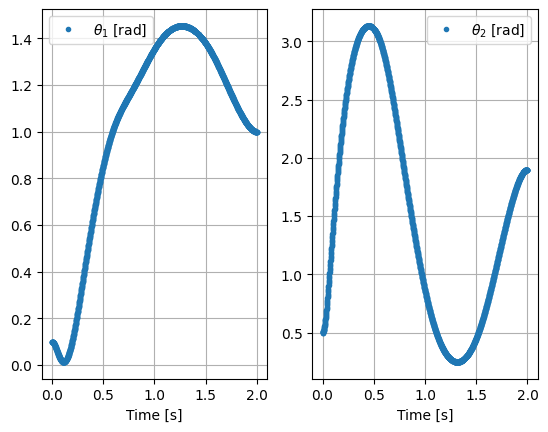

In [15]:
# Optimal control problem
sol = manipulator(2, animation=False)

### Convexity analysis for Case 2 
1. Object function: Mean-square control effort:  
The mean-square control effort for a system with control inputs $u(t)$ over a time horizon $[0,T]$ can be expressed as:

$ J = \frac{1}{T} \int_{0}^{T} \|u(t)\|^2 \ dt 
 = \frac{1}{T} \int_{0}^{T} \ u(t)^T \cdot u(t)  \, dt 
$

This is a quadratic function of the control inputs $\ u(t)$ :  
$ f(u) = \ u(t)^t Q u(t) $  
The function is convex if and only if matrix Q is positive semi-definite ($ Q \geq 0 $). In this case Q is 2*2 identity matrix which is positive semi-definite, so the objective function is convex.  

2. System dynamics: State-space representation  
The ssystem dynamics for torque control robot is nonlinear as shown in state-space model. Nonlinear dynamics   
introduce multiple feasible solutions to the control problem. Different trajectories might avoid ostacles in different ways while still reach the same final position.
3. Constraints  
The constraints of this problem are given by:  
$\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$  
$\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ in $2$ seconds  
$\dot{\theta}_{\text{terminal}} = [0.0, 0.0]^T \text{ rad/s}$  
$\dot{\theta}_{\text{terminal}} = [0.0, 0.0]^T \text{ rad/s}$  
$|\theta_2| < \pi$  

The constraints for this problem is affine, linear constraints do not affect the convexity of an optimization problem.  

Based on the analysis above, the problem could be nonconvex as the nonlinear dynamics. To prove it's nonconvex, we could try to prove the non-uniqueness of the optimal trajecotry which is common is nonlinear and nonconvex problems. By changing the numerical method parameters(shooting intervals), we could find a different optimal trajectory.




## Q3 - Time-optimal control problem

3. For case 1 (acceleration-controlled robot), formulate a time-optimal control problem that

    a. moves from initial joint positions $\theta_{\text{initial}} = [0.1, 0.5]^T \text{ rad}$ to terminal joint positions $\theta_{\text{terminal}} = [1.0, 1.9]^T \text{ rad}$ (in minimum time), and

    b. starts and terminates with zero joint velocities,

    c. satisfies the following control bounds: $-10 \text{ rad}/\text{s}^2 \leq \ddot{\theta_r} \leq 10 \text{ rad}/\text{s}^2$,

    d. the robot avoids self-collision, 

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).

    Is this problem convex or not? Briefly motivate your answer.
    Implement and solve this problem and plot the resulting state and control trajectories.


### To check whether it makes sense for the acceleration to be plotted as stairs

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2708
Number of nonzeros in inequality constraint Jacobian.:     1360
Number of nonzeros in Lagrangian Hessian.............:     1054

Total number of variables............................:      905
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      608
Total number of inequality constraints...............:     1209
        inequality constraints with only lower bounds:      756
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      453

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.90e+00 3.50e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

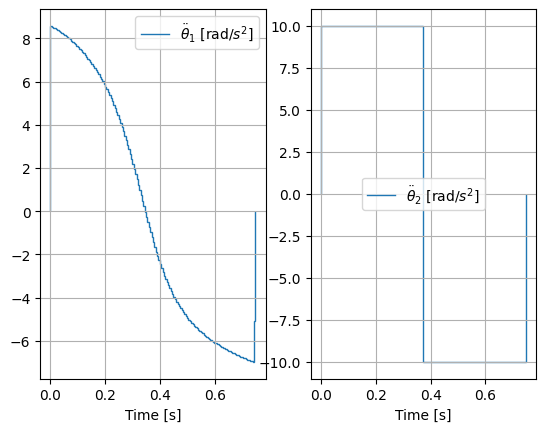

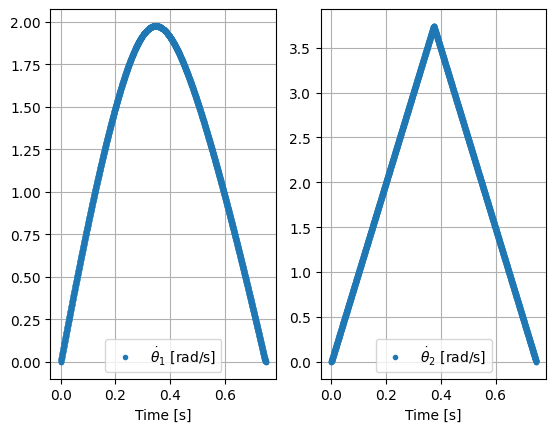

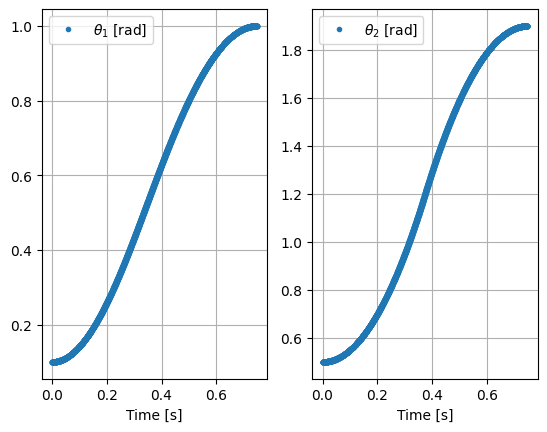

In [30]:
def manipulator_time_optimal(animation=False):
    # Define the dynamics
    def M(theta1, theta2):
        return vertcat(horzcat(m1*l1**2 + m2*(l1**2 + 2*l1*l2*cos(theta2) + l2**2), m2*(l1*l2*cos(theta2) + l2**2)),
                        horzcat(m2*(l1*l2*cos(theta2) + l2**2), m2*l2**2) )

    def c(theta1, theta2, theta1_dot, theta2_dot):
        return vertcat(-m2*l1*l2*sin(theta2)*theta2_dot*(2*theta1_dot + theta2_dot),
                    m2*l1*l2*sin(theta2)*theta1_dot**2)

    def g(theta1, theta2):
        return vertcat((m1 + m2)*l1*9.81*cos(theta1) + m2*l2*9.81*cos(theta1+theta2),
                    m2*l2*9.81*cos(theta1+theta2))

    def f(theta1, theta2, theta1_dot, theta2_dot, torque1=0, torque2=0): # Returns \ddot{\theta} = M^(-1) * (torque - c - g) 
        M_ = M(theta1, theta2)
        c_ = c(theta1, theta2, theta1_dot, theta2_dot)
        g_ = g(theta1, theta2)
        return solve(M_, vertcat(torque1 - c_[0] - g_[0], torque2 - c_[1] - g_[1]))

    ocp = Ocp(T=FreeTime(1.0)) # Time horizon


    # Define the states
    theta1 = ocp.state()
    theta2 = ocp.state()
    theta1_dot = ocp.state()
    theta2_dot = ocp.state()

    # Defince controls
    theta1_ddot = ocp.control()
    theta2_ddot = ocp.control()

    # Specify ODE
    ocp.set_der(theta1, theta1_dot)
    ocp.set_der(theta2, theta2_dot)
    ocp.set_der(theta1_dot, theta1_ddot)
    ocp.set_der(theta2_dot, theta2_ddot)

    # Lagrange objective
    ocp.add_objective(ocp.T)

    # Motion constraints
    epsilon = 1e-2
    # check if this is enough to avoid self-collision
    ocp.subject_to(theta2 <= pi - epsilon)  # Ensure theta2 is less than pi - epsilon
    ocp.subject_to(theta2 >= -pi + epsilon)  # Ensure theta2 is greater than -pi + epsilon
    # acceleration limits
    ocp.subject_to(theta1_ddot <= 10)
    ocp.subject_to(theta1_ddot >= -10)
    ocp.subject_to(theta2_ddot <= 10)
    ocp.subject_to(theta2_ddot >= -10)
    # avoid collision with the ground
    y_position_link1 = l1 * sin(theta1)
    y_position_end_effector = l1 * sin(theta1) + l2 * sin(theta1 + theta2)
    ocp.subject_to(y_position_link1 > 0)
    ocp.subject_to(y_position_end_effector > 0)

    # Initial constraints
    ocp.subject_to(ocp.at_t0(theta1)==0.1)
    ocp.subject_to(ocp.at_t0(theta2)==0.5)
    ocp.subject_to(ocp.at_t0(theta1_dot)==0.)
    ocp.subject_to(ocp.at_t0(theta2_dot)==0.)

    # End constraints
    ocp.subject_to(ocp.at_tf(theta1)==1.0)
    ocp.subject_to(ocp.at_tf(theta2)==1.9)
    ocp.subject_to(ocp.at_tf(theta1_dot)==0.)
    ocp.subject_to(ocp.at_tf(theta2_dot)==0.)

    # Pick a solver
    ocp.solver('ipopt')

    # Pick a solution method
    ocp.method(MultipleShooting(N=150, M=1, intg='rk'))

    # Solve the OCP
    sol = ocp.solve()

    # Plot the solution
    t_u1, theta1_ddot_sol = sol.sample(theta1_ddot, grid='control')
    t_u2, theta2_ddot_sol = sol.sample(theta2_ddot, grid='control')
    t_x1, theta1_sol = sol.sample(theta1,  grid='integrator', refine=20)
    t_x2, theta2_sol = sol.sample(theta2,  grid='integrator', refine=20)
    t_x3, theta1_dot_sol = sol.sample(theta1_dot,  grid='integrator', refine=20)
    t_x4, theta2_dot_sol = sol.sample(theta2_dot,  grid='integrator', refine=20)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.stairs(theta1_ddot_sol[:-1], t_u1, label=r'$\ddot{\theta}_1$ [rad/$s^2$]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stairs(theta2_ddot_sol[:-1], t_u2, label=r'$\ddot{\theta}_2$ [rad/$s^2$]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    filename = f"./imgs/timeoptimal-acc.png"
    plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x3, theta1_dot_sol, '.', label=r'$\dot{\theta}_1$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x4, theta2_dot_sol, '.', label=r'$\dot{\theta}_2$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    filename = f"./imgs/timeoptimal-vel.png"
    plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x1, theta1_sol, '.', label=r'$\theta_1$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x2, theta2_sol, '.', label=r'$\theta_2$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    filename = f"./imgs/timeoptimal-pos.png"
    plt.savefig(filename, dpi=700, format='png', bbox_inches='tight')
    plt.show()

    # Create animation
    if animation:
        create_animation(sol=sol, case=1, theta1=theta1, theta2=theta2, theta1_dot=theta1_dot, 
                        theta2_dot=theta2_dot, control1=theta1_ddot, control2=theta2_ddot, name='Q3.gif')

    return sol

# Optimal control problem
sol = manipulator_time_optimal(animation=False)

## Q4 - Forward kinematics equation

The transformation matrix ${}^0T_1$ is given by:

$
{}^0T_1 = \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) &  l_1 \cos(\theta_1) \\
\sin(\theta_1) & \cos(\theta_1) &  l_1 \sin(\theta_1) \\
0 & 0  & 1
\end{bmatrix}
$

The transformation matrix ${}^1T_2$ is given by:

$
{}^1T_2 = \begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) & l_2 \cos(\theta_2) \\
\sin(\theta_2) & \cos(\theta_2) &  l_2 \sin(\theta_2) \\
0 & 0 & 1
\end{bmatrix}
$

The combined transformation matrix ${}^0T_2$ is given by:

$
\begin{aligned}
    {}^0T_2 &= {}^0T_1 {}^1T_2 \\
    &= \begin{bmatrix}
    \cos(\theta_1 + \theta_2) & -\sin(\theta_1 + \theta_2) & l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) \\
    \sin(\theta_1 + \theta_2) & \cos(\theta_1 + \theta_2) & l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2) \\
    0 & 0 &  1
    \end{bmatrix}
\end{aligned}
$

From ${}^0T_2$, the position and orientation of the end effector can be derived as follows:

The $x$-coordinate of the end effector:
$
x_{\text{ee}} = {}^0T_2[0, 2]
$

The $y$-coordinate of the end effector:
$
y_{\text{ee}} = {}^0T_2[1, 2]
$

The yaw angle (orientation) of the end effector:
$
\text{yaw}_{\text{ee}} = \text{atan2}({}^0T_2[1, 0], {}^0T_2[0, 0])
$

In [11]:
def forward_kinematics(theta1, theta2):
    T_01 = vertcat(horzcat(cos(theta1), -sin(theta1), l1*cos(theta1)),
                horzcat(sin(theta1), cos(theta1), l1*sin(theta1)),
                horzcat(0, 0, 1))
    T_12 = vertcat(horzcat(cos(theta2), -sin(theta2), l2*cos(theta2)),
                horzcat(sin(theta2), cos(theta2), l2*sin(theta2)),
                horzcat(0, 0, 1))
    T_02 = mtimes(T_01, T_12)

    T_des = vertcat(horzcat(cos(theta1+theta2), -sin(theta1+theta2), l1*cos(theta1)+l2*cos(theta1+theta2)),
                horzcat(sin(theta1+theta2), cos(theta1+theta2), l1*sin(theta1)+l2*sin(theta1+theta2)),
                horzcat(0, 0, 1))
    print (T_02 - T_des)

    # From T_02, derive the position and the orientation of the end effector
    x_ee = T_02[0, 2]
    y_ee = T_02[1, 2]
    yaw_ee = atan2(T_02[1, 0], T_02[0, 0])
    
    return x_ee, y_ee, yaw_ee

# Test forward kinematics
#x_ee, y_ee, yaw_ee = forward_kinematics(0.1, 0.5)
#print(f'End effector position and yaw: ({x_ee}, {y_ee}, {yaw_ee})')

def inverse_transform(x_ee,y_ee,yaw_ee):
    # Calculate distance from the origin to the end-effector
    r2 = x_ee**2 + y_ee**2
    r = np.sqrt(r2)

    # Calculate theta2 using the law of cosines
    cos_theta2 = (r2 - l1**2 - l2**2) / (2 * l1 * l2)
    theta2 = np.arccos(cos_theta2)

    # Calculate theta1 using arctan2
    theta1 = np.arctan2(y_ee, x_ee) - np.arctan2(l2 * np.sin(theta2), l1 + l2 * np.cos(theta2))

    return theta1, theta2

theta1_sol, theta2_sol = inverse_transform(0.4, 0.4, 1.8)
# print the positions of the joints and end effector
x1 = l1 * np.cos(theta1_sol)
y1 = l1 * np.sin(theta1_sol)
x2 = x1 + l2 * np.cos(theta1_sol + theta2_sol)
y2 = y1 + l2 * np.sin(theta1_sol + theta2_sol)
print(f'Joint 1 position: ({x1}, {y1})')
print(f'Joint 2 position: ({x2}, {y2})')

Joint 1 position: (0.48708286933869704, 0.11291713066130296)
Joint 2 position: (0.4, 0.4)


## Q5 - Torque-controlled robot

5. For case 2 (torque-controlled robot), formulate an optimal control problem that

    a. minimizes the mean-square control effort (so the mean-square joint torques), and
    
    b. moves the robot from initial end effector pose $[0.8 \text{ m} , 0.0 \text{ m}, 0.0 \text{ rad}]^T$ to terminal end effector pose $[0.4 \text{ m} , 0.4 \text{ m}, 1.8 \text{ rad}]^T$ in $2$ seconds, and

    c. starts and terminates with zero joint velocities,

    d. the robot avoids self-collision, and

    e. the robot avoids collision with the ground (assume the ground is at $y = 0$).

    

In [ ]:
import numpy as np

def yaw_angle(x_ee, y_ee):
    """
    Calculate the joint angles of a 2-link planar manipulator given the end-effector position.

    Parameters:
    x_ee (float): x-coordinate of the end-effector
    y_ee (float): y-coordinate of the end-effector

    Returns:
    tuple: (yaw) angle in radians if reachable, otherwise None
    """
    
    # Calculate the distance from the origin to the end-effector
    distance = np.sqrt(x_ee**2 + y_ee**2)
    
    # Check if the position is reachable
    if distance > (l1 + l2) or distance < abs(l1 - l2):
        print("The position is unreachable.")
        return None
    
    # Solve for theta2 using the law of cosines
    cos_theta2 = (x_ee**2 + y_ee**2 - l1**2 - l2**2) / (2 * l1 * l2)
    theta2 = np.arccos(np.clip(cos_theta2, -1.0, 1.0))  # Ensure value is within [-1, 1] to avoid numerical issues

    # Solve for theta1 using geometry
    k1 = l1 + l2 * np.cos(theta2)
    k2 = l2 * np.sin(theta2)
    theta1 = np.arctan2(y_ee, x_ee) - np.arctan2(k2, k1)

    yaw = theta1 + theta2

    return yaw

# Test 

print(yaw_angle(0.4, 0.4))
print(yaw_angle(0.8,0))
print(yaw_angle(0.2,0))
print(yaw_angle(0.1,0))
print(yaw_angle(0.9,0))


1.8653118119030334
0.0
3.141592653589793
The position is unreachable.
None
The position is unreachable.
None


#### Infeasibility analysis
The problem is infeasible due to the constraint conflict between position of the end effector and yaw angle of the end effector.To make the problem feasible, we can remove the yaw angle restriction.  
Specifically, the length of both link are known at the beginning, to check whether a positon is avaliable for end-effector, we just need to draw 2 circles. The first circle has its center at the origin of the coordinate system, with a radius equal to the length of link 1. The second circle is centered at the coordinate position of the end effector, with a radius equal to the length of link 2. If the desired position of the end effector is reachable, these two circles will intersect at one or two points. In such a case, the orientation of the end effector is uniquely determined.  
The initial pose of end effector $[0.8 \text{ m} , 0.0 \text{ m}, 0.0 \text{ rad}]^T$, according to the method mentioned above, the angle of the end effector is  $0.0 \text{ rad}$ , so the angle constraint of initial pose is redudant.  
The end pose of end effector is $[0.4 \text{ m} , 0.4 \text{ m}, 1.8 \text{ rad}]^T$, the yaw angle is 1.8653118119030334 rad.



(mac(horzcat(horzcat(cos(x1), (-sin(x1)), (0.5*cos(x1)))', horzcat(sin(x1), cos(x1), (0.5*sin(x1)))', [[0, 0, 1]]')',horzcat(horzcat(cos(x2), (-sin(x2)), (0.3*cos(x2)))', horzcat(sin(x2), cos(x2), (0.3*sin(x2)))', [[0, 0, 1]]')',zeros(3x3))-horzcat(horzcat(cos((x1+x2)), (-sin((x1+x2))), ((0.5*cos(x1))+(0.3*cos((x1+x2)))))', horzcat(sin((x1+x2)), cos((x1+x2)), ((0.5*sin(x1))+(0.3*sin((x1+x2)))))', [[0, 0, 1]]')')
(mac(horzcat(horzcat(cos(x1), (-sin(x1)), (0.5*cos(x1)))', horzcat(sin(x1), cos(x1), (0.5*sin(x1)))', [[0, 0, 1]]')',horzcat(horzcat(cos(x2), (-sin(x2)), (0.3*cos(x2)))', horzcat(sin(x2), cos(x2), (0.3*sin(x2)))', [[0, 0, 1]]')',zeros(3x3))-horzcat(horzcat(cos((x1+x2)), (-sin((x1+x2))), ((0.5*cos(x1))+(0.3*cos((x1+x2)))))', horzcat(sin((x1+x2)), cos((x1+x2)), ((0.5*sin(x1))+(0.3*sin((x1+x2)))))', [[0, 0, 1]]')')
(mac(horzcat(horzcat(cos(x1), (-sin(x1)), (0.5*cos(x1)))', horzcat(sin(x1), cos(x1), (0.5*sin(x1)))', [[0, 0, 1]]')',horzcat(horzcat(cos(x2), (-sin(x2)), (0.3*cos(x2)))

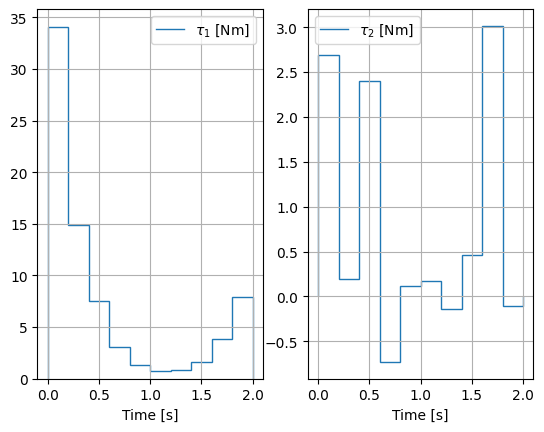

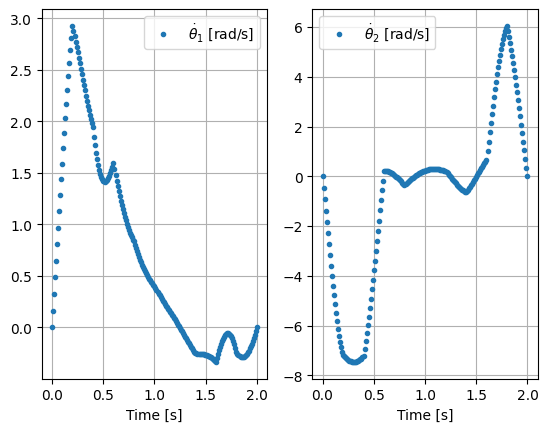

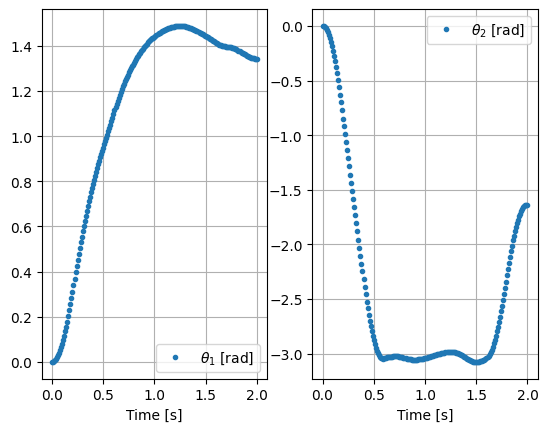

In [ ]:
def manipulator_torque_optimal(animation=False):
    # Define the dynamics
    def M(theta1, theta2):
        return vertcat(horzcat(m1*l1**2 + m2*(l1**2 + 2*l1*l2*cos(theta2) + l2**2), m2*(l1*l2*cos(theta2) + l2**2)),
                        horzcat(m2*(l1*l2*cos(theta2) + l2**2), m2*l2**2) )

    def c(theta1, theta2, theta1_dot, theta2_dot):
        return vertcat(-m2*l1*l2*sin(theta2)*theta2_dot*(2*theta1_dot + theta2_dot),
                    m2*l1*l2*sin(theta2)*(theta1_dot**2))

    def g(theta1, theta2):
        return vertcat((m1 + m2)*l1*9.81*cos(theta1) + m2*l2*9.81*cos(theta1+theta2),
                    m2*l2*9.81*cos(theta1+theta2))

    def f(theta1, theta2, theta1_dot, theta2_dot, torque1=0, torque2=0): # Returns \ddot{\theta} = M^(-1) * (torque - c - g) 
        M_ = M(theta1, theta2)
        c_ = c(theta1, theta2, theta1_dot, theta2_dot)
        g_ = g(theta1, theta2)
        return solve(M_, vertcat(torque1 - c_[0] - g_[0], torque2 - c_[1] - g_[1]))

    ocp = Ocp(T=2.0) # Time horizon

    # Define the states
    theta1 = ocp.state()
    theta2 = ocp.state()
    theta1_dot = ocp.state()
    theta2_dot = ocp.state()

    # Defince controls
    torque1 = ocp.control()
    torque2 = ocp.control()

    # Specify ODE
    ocp.set_der(theta1, theta1_dot)
    ocp.set_der(theta2, theta2_dot)
    ocp.set_der(theta1_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[0])
    ocp.set_der(theta2_dot, f(theta1, theta2, theta1_dot, theta2_dot, torque1, torque2)[1])

    # Lagrange objective
    obj = ocp.integral(torque1**2 + torque2**2) / 2
    ocp.add_objective(obj)

    # Motion constraints
    epsilon = 0.1
    # check if this is enough to avoid self-collision
    ocp.subject_to(theta2 <= pi - epsilon)  # Ensure theta2 is less than pi - epsilon
    ocp.subject_to(theta2 >= -pi + epsilon)  # Ensure theta2 is greater than -pi + epsilon
    # avoid collision with the ground
    y_position_link1 = l1 * sin(theta1)
    ocp.subject_to(y_position_link1 >= 0) # y_link1 >= 0
    ocp.subject_to(forward_kinematics(theta1, theta2)[1] >= 0) # y_ee >= 0

    # Initial constraints
    ocp.subject_to(ocp.at_t0(forward_kinematics(theta1, theta2)[0])== 0.8) # x_ee = 0.8
    ocp.subject_to(ocp.at_t0(forward_kinematics(theta1, theta2)[1])== 0.) # y_ee = 0.0
    ocp.subject_to(ocp.at_t0(forward_kinematics(theta1, theta2)[2])== 0.) # yaw_ee = 0.0
    ocp.subject_to(ocp.at_t0(theta1_dot)==0.)
    ocp.subject_to(ocp.at_t0(theta2_dot)==0.)

    # End constraints
    ocp.subject_to(ocp.at_tf(forward_kinematics(theta1, theta2)[0])==0.4) # x_ee = 0.4
    ocp.subject_to(ocp.at_tf(forward_kinematics(theta1, theta2)[1])==0.4) # y_ee = 0.4
    #ocp.subject_to(ocp.at_tf(forward_kinematics(theta1, theta2)[2])==1.8) # yaw_ee = 1.8
    ocp.subject_to(ocp.at_tf(theta1_dot)==0.)
    ocp.subject_to(ocp.at_tf(theta2_dot)==0.)

    # Pick a solver
    ocp.solver('ipopt')

    # Pick a solution method
    ocp.method(MultipleShooting(N=10, M=1, intg='rk'))

    # Solve the OCP
    sol = ocp.solve()

    # Plot the solution
    t_u1, torque1_sol = sol.sample(torque1, grid='control')
    t_u2, torque2_sol = sol.sample(torque2, grid='control')
    t_x1, theta1_sol = sol.sample(theta1,  grid='integrator', refine=20)
    t_x2, theta2_sol = sol.sample(theta2,  grid='integrator', refine=20)
    t_x3, theta1_dot_sol = sol.sample(theta1_dot,  grid='integrator', refine=20)
    t_x4, theta2_dot_sol = sol.sample(theta2_dot,  grid='integrator', refine=20)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.stairs(torque1_sol[:-1], t_u1, label=r'$\tau_1$ [Nm]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stairs(torque2_sol[:-1], t_u2, label=r'$\tau_2$ [Nm]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x3, theta1_dot_sol, '.', label=r'$\dot{\theta}_1$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x4, theta2_dot_sol, '.', label=r'$\dot{\theta}_2$ [rad/s]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(t_x1, theta1_sol, '.', label=r'$\theta_1$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_x2, theta2_sol, '.', label=r'$\theta_2$ [rad]')
    plt.xlabel("Time [s]")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create animation
    if animation:
        create_animation(sol=sol, theta1=theta1, theta2=theta2, theta1_dot=theta1_dot, 
                        theta2_dot=theta2_dot, control1=torque1, control2=torque2, name='Q5.gif')

    return sol

# Optimal control problem
sol = manipulator_torque_optimal(animation=False)